In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"rizkyely","key":"a76d26afe6e59d40455c73999d68f31c"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download linjustin/train-val-test-tcga-coad-msi-mss

100% 5.48G/5.48G [01:48<00:00, 57.6MB/s]
100% 5.48G/5.48G [01:48<00:00, 54.3MB/s]


In [ ]:
import os
import zipfile

local_zip = '/content/train-val-test-tcga-coad-msi-mss.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [ ]:
# Mendefenisikan data untuk test dan train
base_dir = '/content/tcga_coad_msi_mss'

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

train_msimut_dir = os.path.join(train_dir, 'MSIMUT')
train_mss_dir = os.path.join(train_dir, 'MSS')

val_msimut_dir = os.path.join(val_dir, 'MSIMUT')
val_mss_dir = os.path.join(val_dir, 'MSS')

In [ ]:
print('Train MSIMUT :', os.listdir(train_msimut_dir)[:2])
print('Train MSS :', os.listdir(train_mss_dir)[:2])

print('Val MSIMUT :', os.listdir(val_msimut_dir)[:2])
print('Val MSS :', os.listdir(val_mss_dir)[:2])


Train MSIMUT : ['blk-PERRITIAVNTH-TCGA-5M-AAT6-01Z-00-DX1.jpg', 'blk-FWRWDVYFLMLV-TCGA-CM-6171-01Z-00-DX1.jpg']
Train MSS : ['blk-THTYAMNTQGGH-TCGA-AY-A71X-01Z-00-DX1.jpg', 'blk-SIGEWWHRSRQN-TCGA-AA-A02F-01Z-00-DX1.jpg']
Val MSIMUT : ['blk-VDRAVGHEMWVN-TCGA-CM-6171-01Z-00-DX1.jpg', 'blk-RFHTYHINPLAN-TCGA-AA-A01P-01Z-00-DX1.jpg']
Val MSS : ['blk-LTDWRLTYDTGW-TCGA-CK-4950-01Z-00-DX1.jpg', 'blk-PFTEEHQQVHMD-TCGA-F4-6809-01Z-00-DX1.jpg']


In [ ]:
print(len(os.listdir(train_msimut_dir)))
print(len(os.listdir(train_mss_dir)))
print(len(os.listdir(val_msimut_dir)))
print(len(os.listdir(val_mss_dir)))

60031
93818
7503
11727


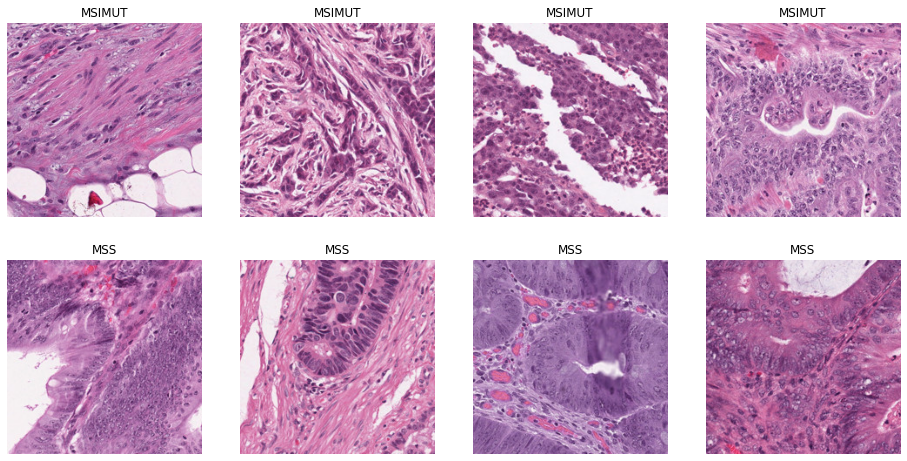

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


nrows = 2
ncols = 4

pic_index = 0

fig = plt.gcf()
fig.set_size_inches( ncols * 4,nrows * 4)

pic_index += 8
msimut_img = [os.path.join(train_msimut_dir, fname) 
                for fname in os.listdir(train_msimut_dir)[pic_index-4:pic_index]]
mss_img  = [os.path.join(train_mss_dir, fname) 
                for fname in os.listdir(train_mss_dir)[pic_index-4:pic_index]]

for i, img_path in enumerate(msimut_img+mss_img):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.title(img_path.split(os.path.sep)[-2])

plt.show()

# 2. Preprocessing Data

In [ ]:
# Tulis Kode Anda Disini
import cv2
import numpy as np

# Gather data test
train_data = []
train_label = []
for r, d, f in os.walk(train_dir):
    for file in f:
        if ".jpg" in file:
            imagePath = os.path.join(r, file)
            image = cv2.imread(imagePath)
            image = cv2.resize(image, (50,50))
            train_data.append(image)
            label = imagePath.split(os.path.sep)[-2]
            train_label.append(label)
            
train_data = np.array(train_data)
train_label = np.array(train_label)

In [ ]:
# Tulis Kode Anda Disini
import cv2
import numpy as np

# Gather data test
val_data = []
val_label = []
for r, d, f in os.walk(val_dir):
    for file in f:
        if ".jpg" in file:
            imagePath = os.path.join(r, file)
            image = cv2.imread(imagePath)
            image = cv2.resize(image, (50,50))
            val_data.append(image)
            label = imagePath.split(os.path.sep)[-2]
            val_label.append(label)
            
val_data = np.array(val_data)
val_label = np.array(val_label)

In [ ]:
print("Train Data = ", train_data.shape)
print("Train Label = ", train_label.shape)
print("Validation Data = ", val_data.shape)
print("Validation Label = ", val_label.shape)

Train Data =  (153849, 50, 50, 3)
Train Label =  (153849,)
Validation Data =  (19230, 50, 50, 3)
Validation Label =  (19230,)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,shear_range=0.2,zoom_range=0.2, horizontal_flip= True)
training_set = train_datagen.flow_from_directory('/content/tcga_coad_msi_mss/train',target_size=(50, 50),batch_size= 32,class_mode="binary")
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('/content/tcga_coad_msi_mss/test',target_size= (50,50), batch_size = 32, class_mode = 'binary')

Found 153849 images belonging to 2 classes.
Found 19233 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Conv2D, Flatten, Dropout,
                                     MaxPooling2D, Activation, BatchNormalization)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

model = Sequential([
    # Conv layer 1/Input layer
    Conv2D(64, kernel_size = (5, 5),padding = 'same', activation = 'relu', 
           input_shape = (50, 50, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2, 2)),
    Dropout(0.25),
    
    # Conv layer 2
    Conv2D(64, kernel_size = (5, 5), padding = 'same', activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2, 2)),
    Dropout(0.25),

    # Conv layer 3
    Conv2D(128, kernel_size = (3, 3), padding = 'same', activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2, 2), strides = (2, 2)),
    Dropout(0.25),
    
    # Conv layer 4
    Conv2D(128, kernel_size = (3, 3), padding = 'same', activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2, 2), strides = (2, 2)),
    Dropout(0.25),

    # Fully connected layer 1
    Flatten(),
    Dense(256, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.25),
    
    # Fully connected last layer
    Dense(1, activation = 'sigmoid')
])

# Standard metrics for binary classification 
metrics = [
    tf.keras.metrics.TruePositives(name = 'tp'),
    tf.keras.metrics.FalsePositives(name = 'fp'),
    tf.keras.metrics.TrueNegatives(name = 'tn'),
    tf.keras.metrics.BinaryAccuracy(name = 'accuracy'),
    tf.keras.metrics.Precision(name = 'precision'),
    tf.keras.metrics.Recall(name = 'recall'),
    tf.keras.metrics.AUC(name = 'auc')
]

initial_lr = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_lr,
    decay_steps = 100000,
    decay_rate = 0.96,
    staircase = True
)

model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = lr_schedule,
                                                  momentum = 0.9,
                                                  nesterov = True),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics = metrics)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 50, 50, 64)        4864      
                                                                 
 batch_normalization_3 (Batc  (None, 50, 50, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 25, 25, 64)       0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 25, 25, 64)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 25, 25, 64)        102464    
                                                                 
 batch_normalization_4 (Batc  (None, 25, 25, 64)      

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.80):
      print("\n\n Akurasi train dan validasi didapat telah mencapai nilai > 80%!")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:

history = model.fit(training_set,
                    epochs = 100,
                    validation_data = test_set,
                    callbacks = callbacks)

Epoch 1/100
4808/4808 [==============================] - ETA: 0s - loss: 0.6806 - tp: 89114.0000 - fp: 56047.0000 - tn: 3984.0000 - accuracy: 0.6051 - precision: 0.6139 - recall: 0.9499 - auc: 0.5288

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


4808/4808 [==============================] - 3388s 705ms/step - loss: 0.6806 - tp: 89114.0000 - fp: 56047.0000 - tn: 3984.0000 - accuracy: 0.6051 - precision: 0.6139 - recall: 0.9499 - auc: 0.5288 - val_loss: 0.6620 - val_tp: 11276.0000 - val_fp: 6919.0000 - val_tn: 586.0000 - val_accuracy: 0.6168 - val_precision: 0.6197 - val_recall: 0.9615 - val_auc: 0.5625
Epoch 2/100
4808/4808 [==============================] - 3395s 706ms/step - loss: 0.6632 - tp: 88665.0000 - fp: 53946.0000 - tn: 6085.0000 - accuracy: 0.6159 - precision: 0.6217 - recall: 0.9451 - auc: 0.5596 - val_loss: 0.6581 - val_tp: 10166.0000 - val_fp: 5773.0000 - val_tn: 1732.0000 - val_accuracy: 0.6186 - val_precision: 0.6378 - val_recall: 0.8668 - val_auc: 0.5806
Epoch 3/100
4808/4808 [==============================] - 3433s 714ms/step - loss: 0.6599 - tp: 87638.0000 - fp: 52098.0000 - tn: 7933.0000 - accuracy: 0.6212 - precision: 0.6272 - recall: 0.9341 - auc: 0.5713 - val_loss: 0.6798 - val_tp: 11724.0000 - val_fp: 7485

In [ ]:
#Normalisasi data set
print("sebelum di Normalisasi ", train_data[0][0][0])



sebelum di Normalisasi  [155 103 161]


In [ ]:
x_train = train_data.astype('float32') / 255.0
x_val = val_data.astype('float32') / 255.0

print("Data setelah di normalisasi : ", x_train[0][0][0])